In [2]:
import pandas as pd
import numpy as np
import os
import pickle
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 18s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
from tqdm import tqdm
from PIL import Image

# extract features from image
features = {}
directory = os.path.join("/kaggle/input/flickr-8k-images-with-captions", 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = os.path.join(directory, img_name)  
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image id
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

100%|██████████| 8091/8091 [09:35<00:00, 14.06it/s]


In [5]:
# store features in pickle
pickle.dump(features, open(os.path.join("/kaggle/working/", 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join("/kaggle/working/", 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [7]:
with open(os.path.join("/kaggle/input/flickr-8k-images-with-captions", 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id, caption  = tokens[0], tokens[1:]
    # remove extension from image id
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 378901.03it/s]


In [9]:
len(mapping)

8091

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            caption = caption.lower()  #convert to lowercase
            caption = caption.replace('[^A-Za-z]', '')  #delete special chars,digit 
            caption = caption.replace('\s+', ' ')  #multiple space remove to single space
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'  #add start and end tags to the caption
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    # total_samples = len(data_keys)
    # while n < total_samples:
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence (onehotencoding)
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0
        
    #         if n % batch_size == 0:
    #             X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    #             yield (X1, X2), y  # Yield a tuple of (inputs1, inputs2, outputs)
    #             X1, X2, y = list(), list(), list()
    # # Yield the remaining samples
    # if X1:
    #     X1, X2, y = np.array(X1), np.array(X2), np.array(y)
    #     yield (X1, X2), y

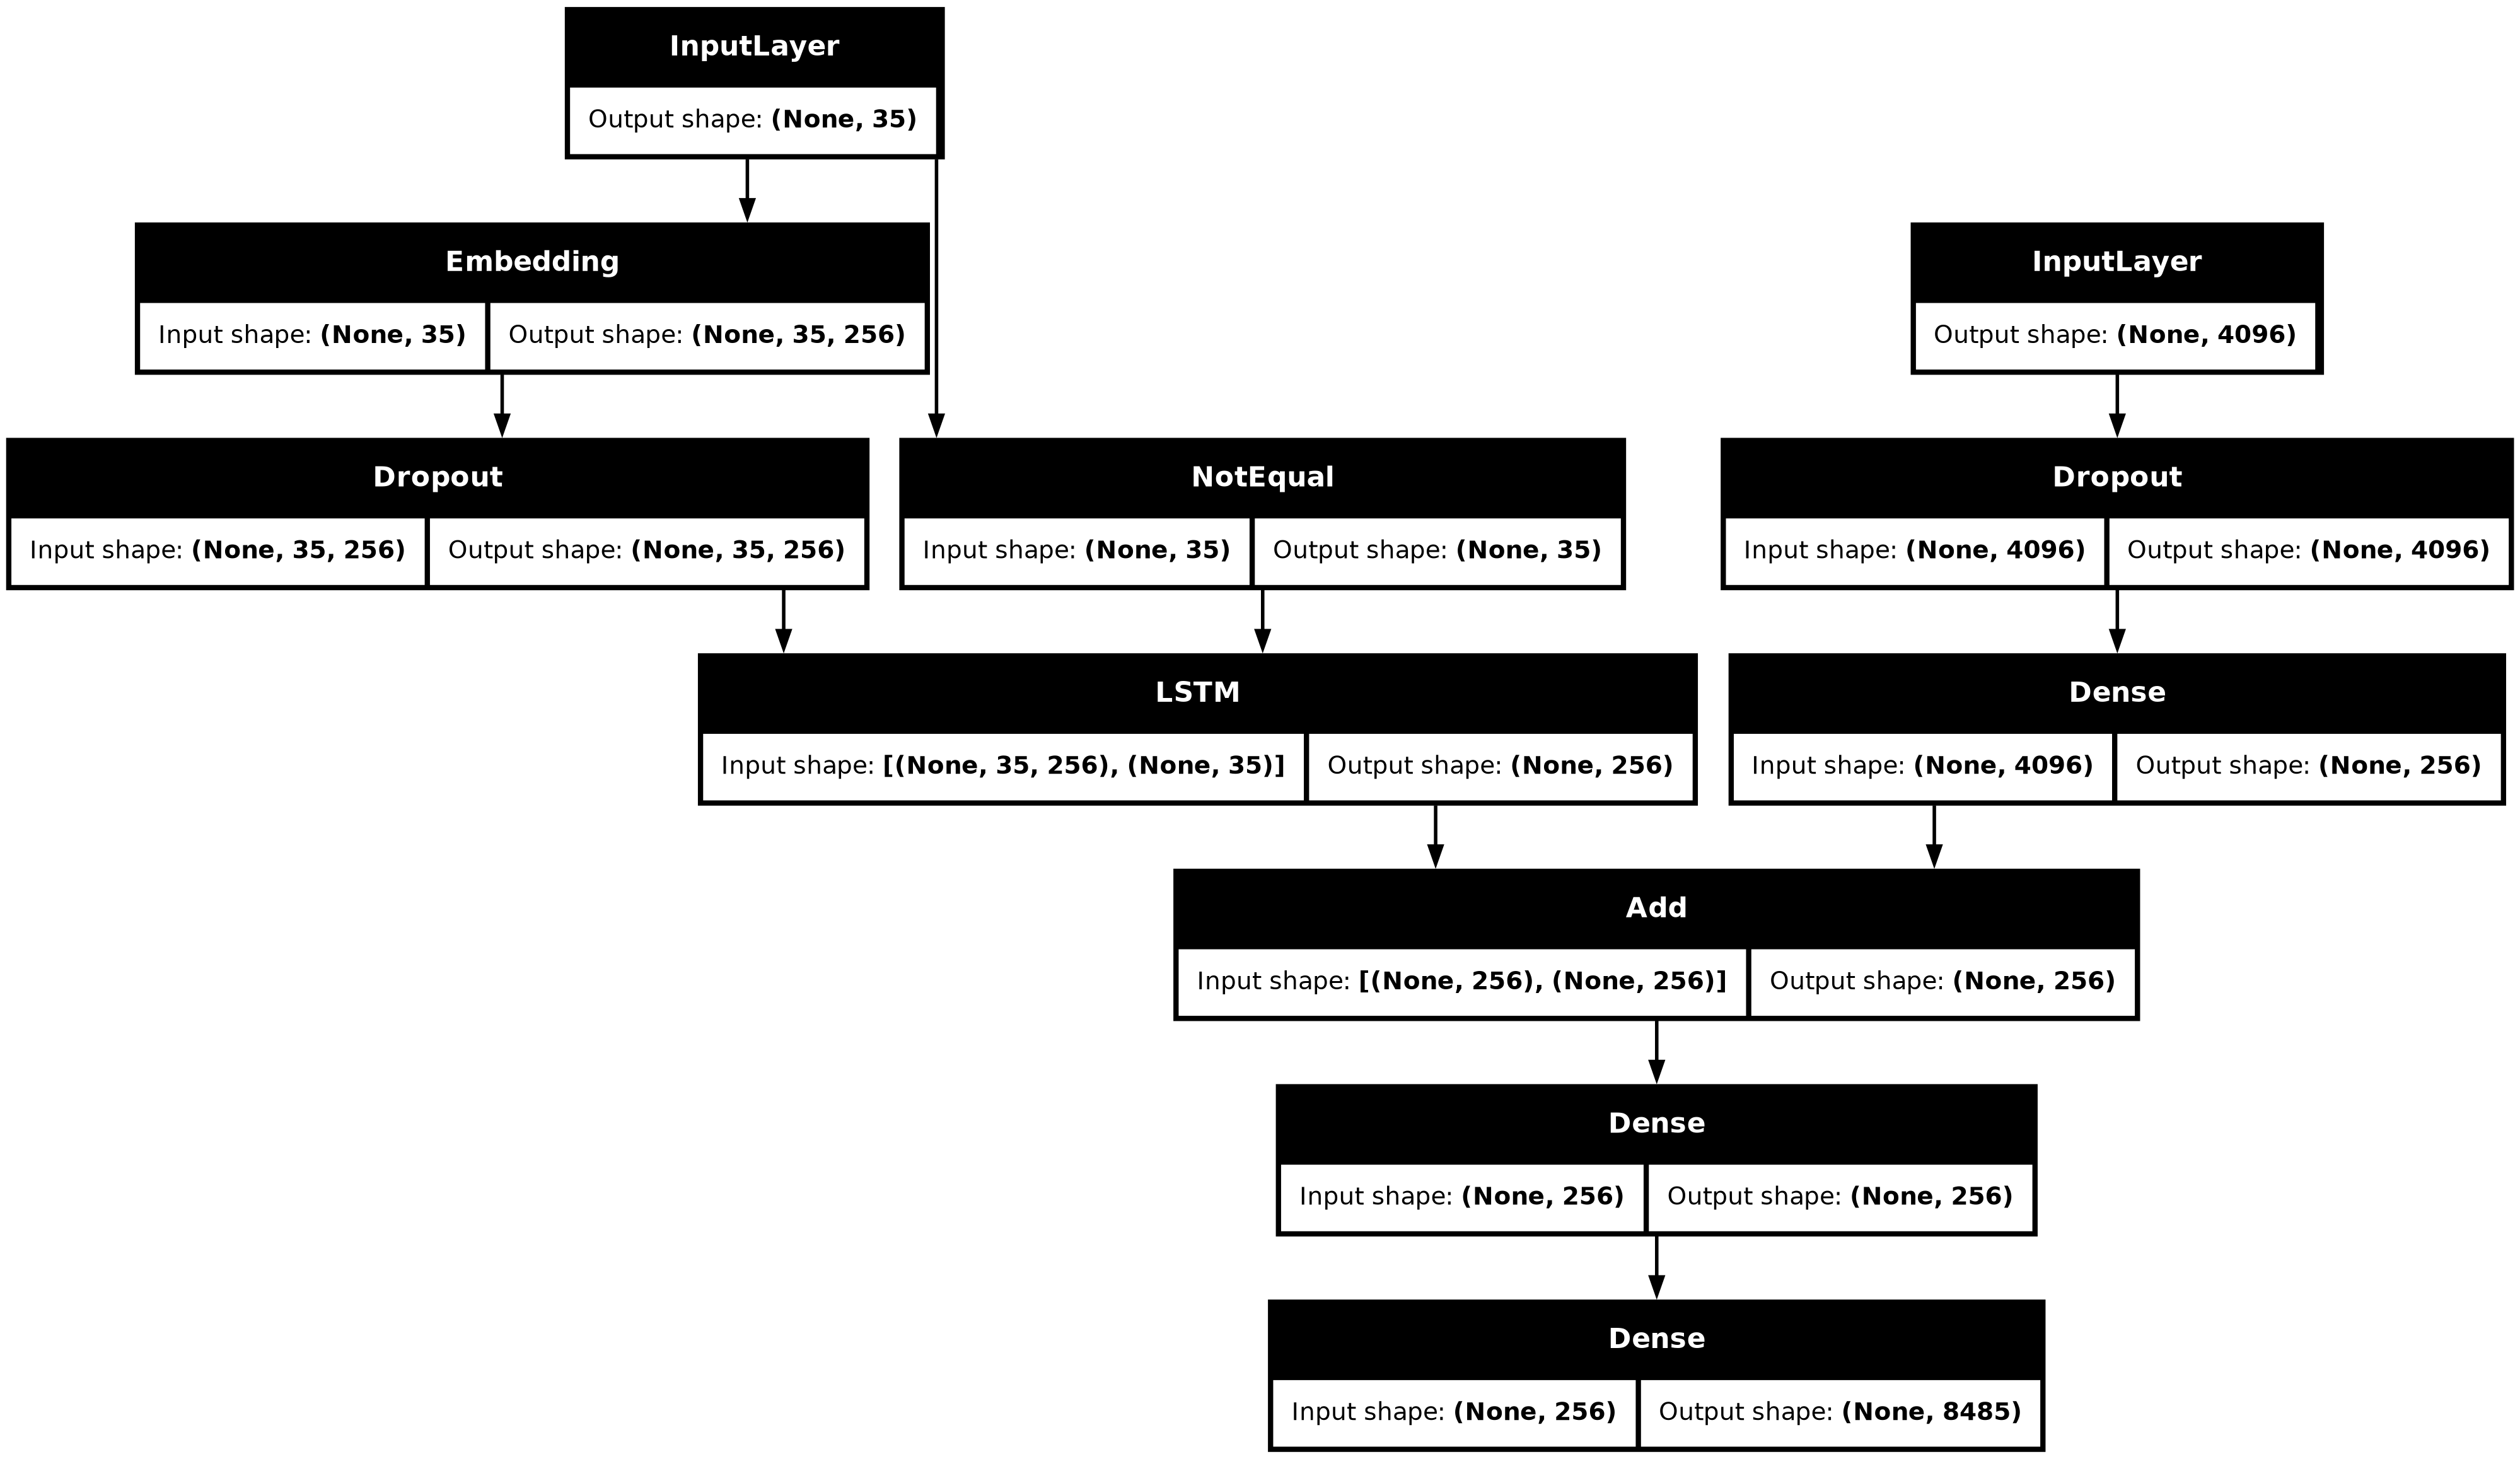

In [22]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder mpdel
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [23]:
# train the model
epochs = 20
batch_size = 64
steps = len(train) // batch_size
# print(len(train) // batch_size)

for i in range(epochs):
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    
    
    # dataset = tf.data.Dataset.from_generator(lambda: generator, output_signature=((tf.TensorSpec(shape=(None, 4096)), tf.TensorSpec(shape=(None, max_length))), tf.TensorSpec(shape=(None, vocab_size))))3

113/113 ━━━━━━━━━━━━━━━━━━━━ 409s 4s/step - loss: 6.1603
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 485ms/step - loss: 4.5106
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - loss: 3.8248
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 502ms/step - loss: 3.4987
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 509ms/step - loss: 3.2802
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 506ms/step - loss: 3.1119
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 503ms/step - loss: 2.9918
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 498ms/step - loss: 2.8871
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - loss: 2.7982
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 508ms/step - loss: 2.7175
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 504ms/step - loss: 2.6518
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 495ms/step - loss: 2.5883
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 503ms/step - loss: 2.5348
113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 502ms/step - loss: 2.4803
113/113 ━━━━━━━━━━━━━━━━━━━━ 56s 500ms/step - loss: 2.4354
113/113 ━━━━━━━━━━━━━━━━━━━━ 58s 511ms/step - loss: 2.4012
113/113 ━━━━━━━━━━━━━━━━━━━━ 55s 486ms/step - loss: 2.3637

In [24]:
# save the model
model.save("flickr" + '/best_model.h5')

In [25]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [33]:
# generate caption for an Image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to eord
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
        
    # Remove 'startseq' from the beginning and 'endseq' from the end
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()

    return final_caption

In [27]:
from nltk.translate.bleu_score import corpus_bleu

# validate with test data
actual, predicted = list(), list()
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calculate BLUE score
print("BLUE-1 : %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLUE-2 : %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [08:17<00:00,  1.63it/s]


BLUE-1 : 0.544165
BLUE-2 : 0.323250


In [34]:
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # Check if the image name is provided
    if not image_name or not isinstance(image_name, str):
        print("Error: Image name must be a non-empty string.")
        return

    # Check if the image has a valid extension
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    if not any(image_name.lower().endswith(ext) for ext in valid_extensions):
        print("Error: Invalid image format. Supported formats are: jpg, jpeg, png, bmp, gif.")
        return

    # Generate the image path
    img_path = os.path.join("/kaggle/input/flickr-8k-images-with-captions", 'Images', image_name)

    # Check if the image file exists
    if not os.path.exists(img_path):
        print(f"Error: The file '{image_name}' does not exist at the specified path.")
        return

    try:
        # Load the image
        image = Image.open(img_path)
    except Exception as e:
        print(f"Error: Could not open the image. Details: {e}")
        return

    # Extract the image ID
    image_id = image_name.split('.')[0]

    # Check if captions are available for the image
    captions = mapping.get(image_id)
    if captions:
        print('-------------------Actual---------------------')
        for caption in captions:
            print(caption)
    else:
        print('No captions available for this image.')

    # Predict the caption
    try:
        y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
        print('----------------Predicted---------------------')
        print(y_pred)
    except Exception as e:
        print(f"Error: Failed to predict the caption. Details: {e}")
        return

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

-------------------Actual---------------------
startseq man in an orange hat starring at something endseq
startseq man wears an orange hat and glasses endseq
startseq man with gauges and glasses is wearing blitz hat endseq
startseq man with glasses is wearing beer can crocheted hat endseq
startseq the man with pierced ears is wearing glasses and an orange hat endseq
----------------Predicted---------------------
man with gauges and hat and pierced face is wearing blitz hat


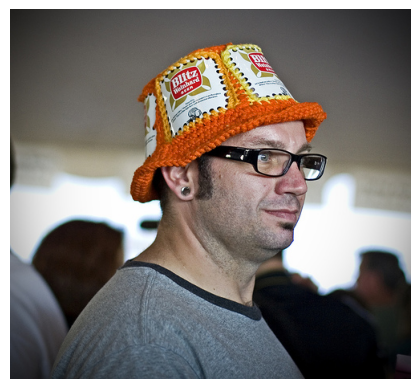

In [35]:
# Example usage
generate_caption("1007129816_e794419615.jpg")

-------------------Actual---------------------
startseq fisherman fishes at the bank of foggy river endseq
startseq man fishes by tree in the morning mist endseq
startseq man fishes under large tree endseq
startseq man fishing near large tree endseq
startseq man is fishing in foggy lake endseq
----------------Predicted---------------------
two people are walking along the edge of the water


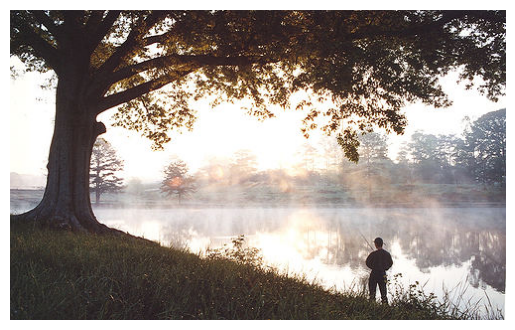

In [36]:
# Example usage
generate_caption("17273391_55cfc7d3d4.jpg")

-------------------Actual---------------------
startseq hikers cross bridge over fast moving stream and rocky scenery endseq
startseq people crossing long bridge over canyon with river endseq
startseq people walk across rope bridge over rocky stream endseq
startseq some hikers are crossing wood and wire bridge over river endseq
startseq three people are looking across rope and wood bridge over river endseq
----------------Predicted---------------------
man in red shirt is climbing rock wall


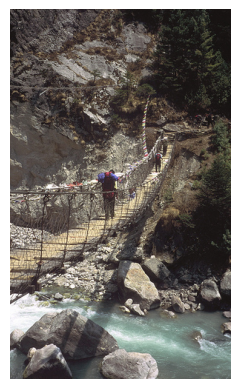

In [37]:
# Example usage
generate_caption("96978713_775d66a18d.jpg")

-------------------Actual---------------------
startseq black and white dog lies on the ground next to little girl on red bicycle in the woods endseq
startseq "a child in red sweatshirt jeans and black bike helmet and dog pose for picture outdoors ." endseq
startseq child is sitting on bike next to her dog endseq
startseq little girl poses on her bike with her dog in the woods endseq
startseq the dog is laying on the ground next to the little girl with the red bike endseq
----------------Predicted---------------------
person and woman are sitting on the side of path


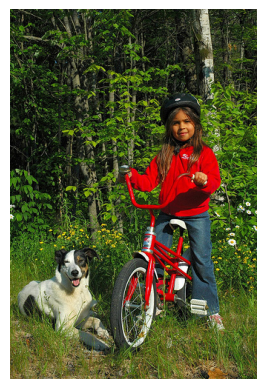

In [38]:
# Example usage
generate_caption("179009558_69be522c63.jpg")

-------------------Actual---------------------
startseq group of bicyclists riding down path in an off road race endseq
startseq group of bikers riding through the woods endseq
startseq group of people are riding bicycles in race endseq
startseq bikers race through forest endseq
startseq many bicyclists racing along dirt road endseq
----------------Predicted---------------------
many people are riding bicycles on dirt road


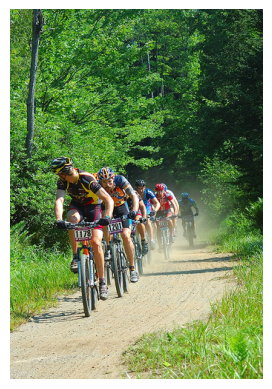

In [39]:
# Example usage
generate_caption("186348874_75b2cf1ec5.jpg")

-------------------Actual---------------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
----------------Predicted---------------------
child roping roping


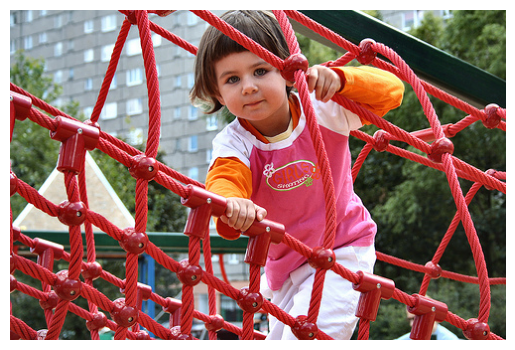

In [40]:
# Example usage
generate_caption("1007320043_627395c3d8.jpg")

-------------------Actual---------------------
startseq little blonde girl is standing in front of water fountain endseq
startseq young blond girl standing in front of large fenced in fountain endseq
startseq young girl standing in front of fountain endseq
startseq young in white dress standing in front of fence and fountain endseq
startseq the little girl in white dress is standing in front of the large park fountain endseq
----------------Predicted---------------------
girl in white shirt and blue shirt is jumping over large sprinkler fountain


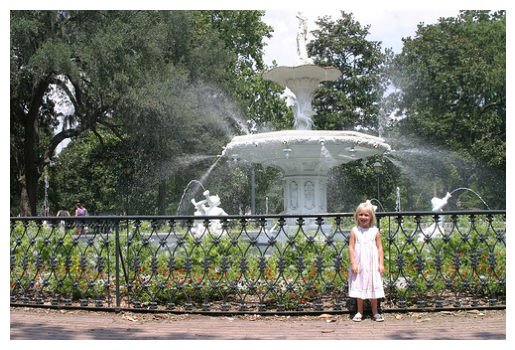

In [41]:
# Example usage
generate_caption("224369028_b1ac40d1fa.jpg")

-------------------Actual---------------------
startseq group of people hold drinks and point at the camera endseq
startseq group of people are holding up drinks and pointing to the camera endseq
startseq group of young people holding bottles and pointing at the camera endseq
startseq several young people posing for this photo holding beers endseq
startseq young adults stand pointing at the person taking the picture endseq
----------------Predicted---------------------
group of people are posing for picture


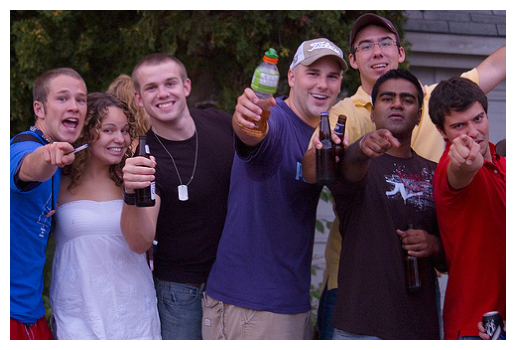

In [42]:
# Example usage
generate_caption("236474697_0c73dd5d8b.jpg")

In [ ]:
# from PIL import Image
# import matplotlib.pyplot as plt

# def generate_caption(image_name):
#     # load the image
#     # image_name = "1007129816_e794419615.jpg"
#     image_id = image_name.split('.')[0]
#     img_path = os.path.join("/kaggle/input/flickr-8k-images-with-captions", 'Images', image_name)
#     image = Image.open(img_path)
#     captions = mapping[image_id]
#     print('-------------------Actual---------------------')
#     for caption in captions:
#         print(caption)
#     # predict the caption
#     y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
#     print('----------------Predicted---------------------')
#     print(y_pred)
#     plt.imshow(image)